# **Accident Detection Using YOLO**

You can download the used dataset from [here](https://universe.roboflow.com/accident-test-set/accident-test-set/dataset/4)

In [2]:
%%capture
!pip install pyyaml
!pip install ultralytics

# Import Necessary Libraries

In [3]:
import yaml
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO, solutions

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Open the dataset

In [9]:
%%capture
! unzip /content/AccidentTestSet.v4i.yolov8.zip

In [ ]:
yaml_path = '/content/data.yaml'
train = '/content/train'
valid = '/content/valid'
test = '/content/test'

# Update Yaml File

In [ ]:
# open yaml filde
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Update the paths in yaml path
data['train'] = '/content/train/images'
data['val'] = '/content/valid/images'
data['test'] = '/content/test/images'

# Save the updated file
with open(yaml_path, 'w') as file:
    yaml.safe_dump(data, file)

In [ ]:
# Update classes
with open(yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Access class names
class_names = data_yaml['names']


class_names[0] = 'accident'
if 'car' not in class_names:
  class_names.insert(2, 'car')
# Update the yaml file
data_yaml['names'] = class_names
data_yaml['nc'] = 3

# Write the updated data back to the YAML file
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file)

print("class names:", class_names)

class names: ['accident', 'severe', 'car']


# EDA

In [ ]:
#Here is about count images in each folder ( train- valid -test)
def count_images(path):
    return len(os.listdir(os.path.join(path, 'images')))

train_count = count_images(train)
val_count = count_images(valid)
test_count = count_images(test)
#print
print(f"Training images: {train_count} \nValidation images: {val_count}\nTest images: {test_count}")

Training images: 10469 
Validation images: 1004
Test images: 649


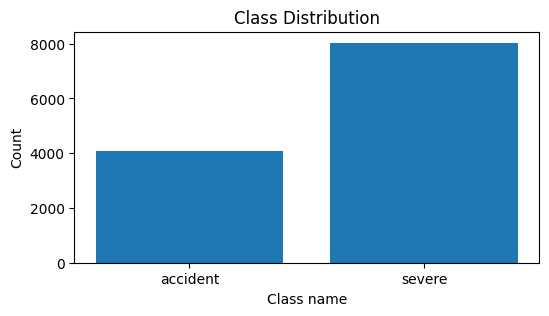

In [ ]:
# Here is about a function to count the class distribution in a given dataset path
def count_class(path):
    labels_path = os.path.join(path, 'labels')
    class_counts = {}

    for label_file in os.listdir(labels_path):
        with open(os.path.join(labels_path, label_file), 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    return class_counts

# Here is about a function to plot class distribution
def plot_class_distribution(train_path, val_path, test_path, class_names):
    # Here is about count the class images in each dataset
    train_counts = count_class(train_path)
    val_counts = count_class(val_path)
    test_counts = count_class(test_path)

    # Here is about sum the counts in datasets (train, test, val)
    combined_counts = {}
    for class_id in set(train_counts.keys()).union(val_counts.keys()).union(test_counts.keys()):
        combined_counts[class_id] = (
            train_counts.get(class_id, 0) +
            val_counts.get(class_id, 0) +
            test_counts.get(class_id, 0)
        )


    class_df = pd.DataFrame(list(combined_counts.items()), columns=['Class', 'Count'])
    class_df['Class'] = class_df['Class'].apply(lambda x: class_names[x])

    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(class_df['Class'], class_df['Count'])
    plt.title('Class Distribution')
    plt.xlabel('Class name')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train, valid, test, class_names)

## The Visualization and Sample of the Dataset

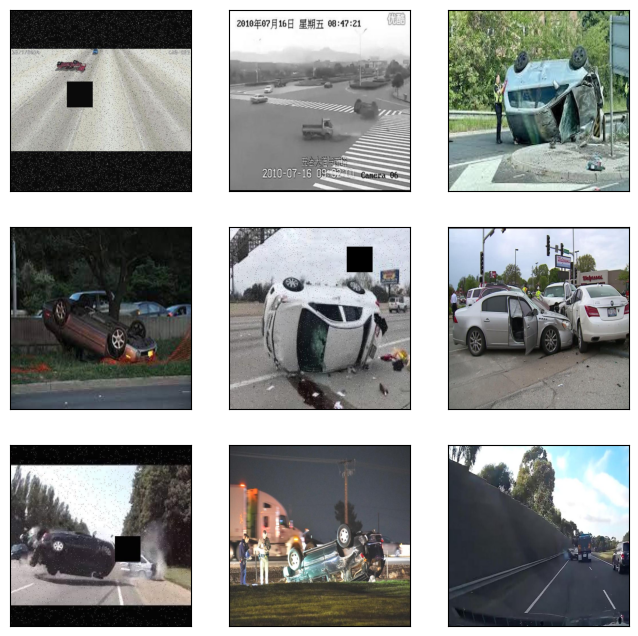

In [ ]:
images_path='/content/train/images'
# Here is get the images
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path)[:9]]

# Here is about read the images and convert to RGB
images = []
for img_path in image_files:
    img = cv2.imread(img_path)  # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    images.append(img)


# Here is about display the images in a 3x3
plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

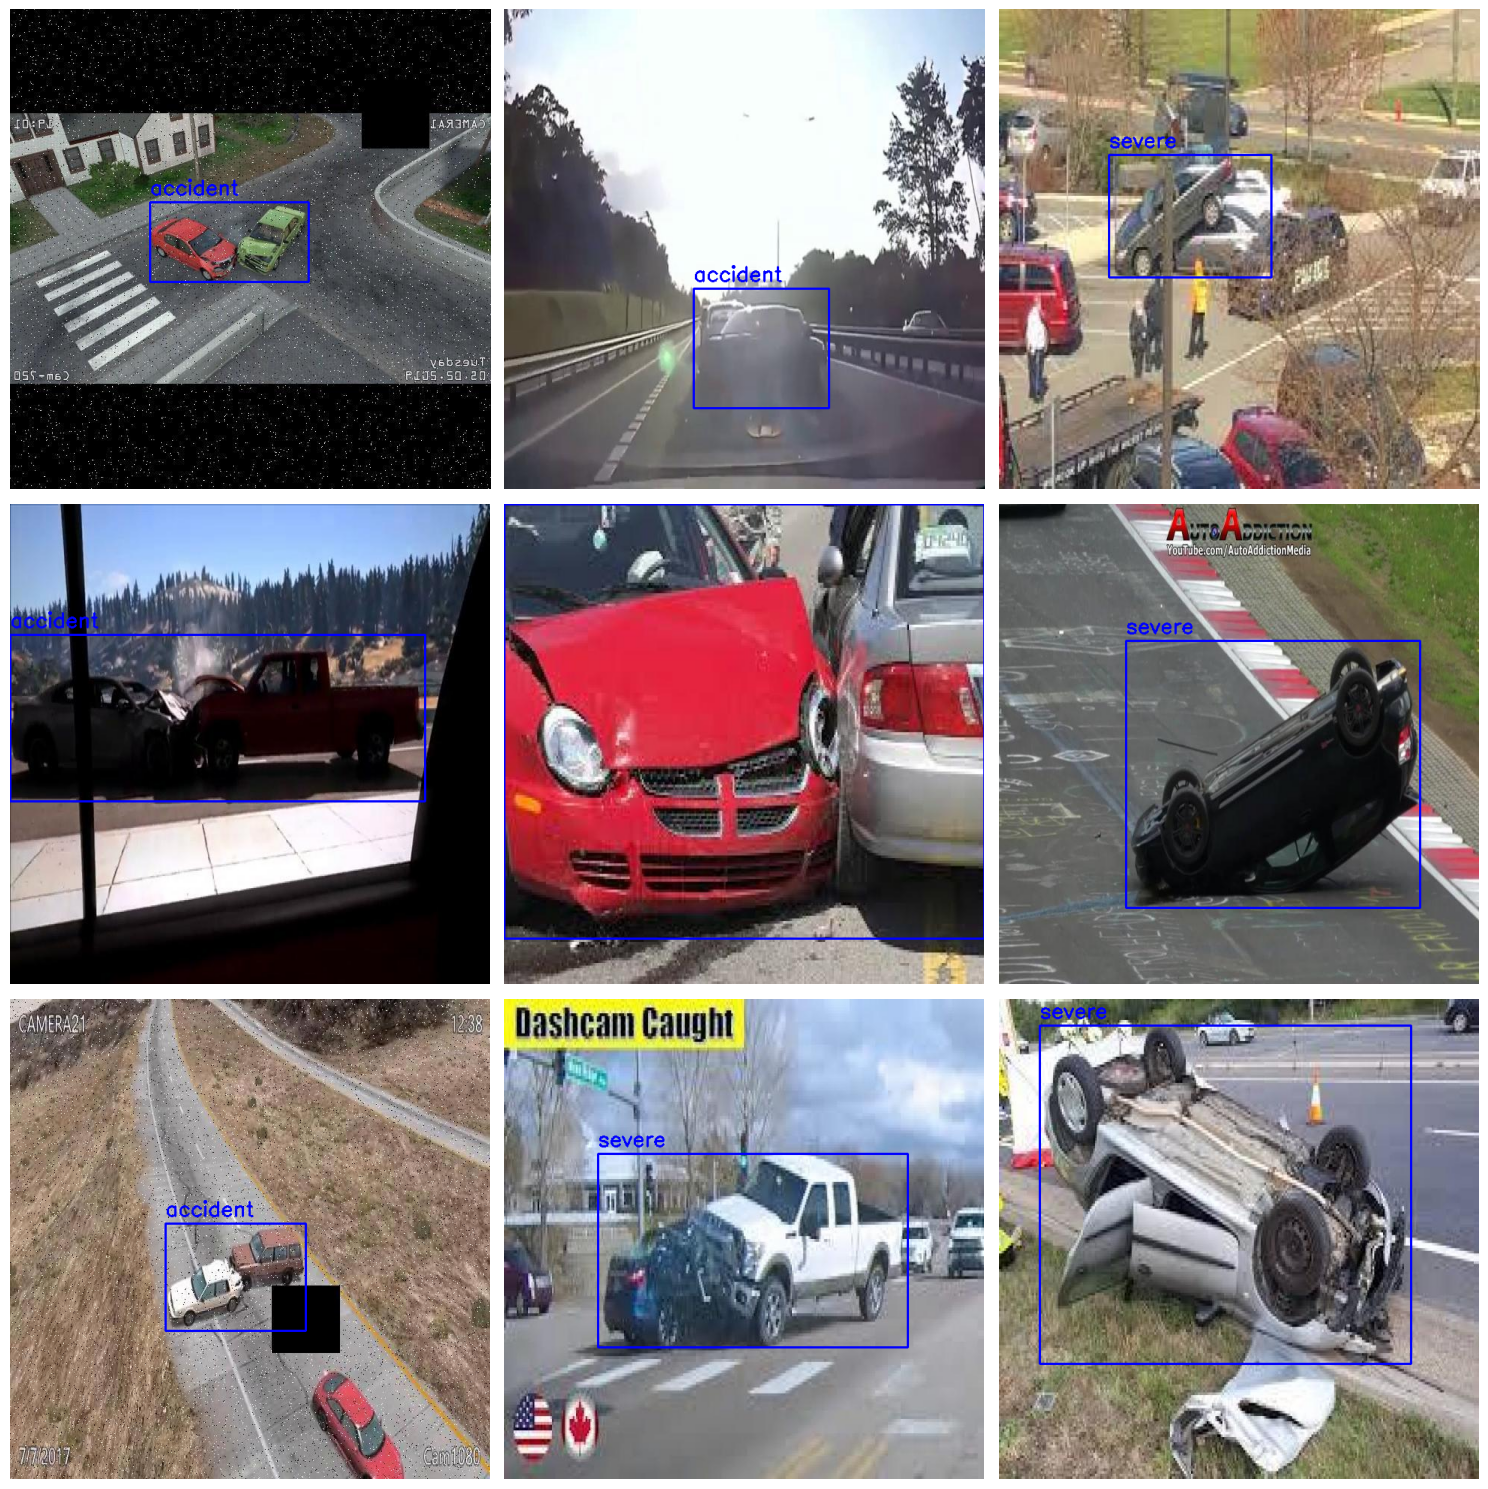

In [ ]:
def display_image_with_boxes(image_path, labels_path, ax):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image at {image_path}")
        return
    height, width, _ = image.shape  # get image dimensions

    # open the label file
    if not os.path.exists(labels_path):
        print(f"Error: Could not find label file at {labels_path}")
        return

    with open(labels_path, 'r') as file:
        labels = file.readlines()

    # loop for each label
    for label in labels:
        try:
            # map to avoid minor errors in rounding
            class_id, x_center, y_center, w, h = map(float, label.split())

            # Convert normalized YOLO coordinates to pixel values
            x1 = int(round((x_center - w / 2) * width))
            x2 = int(round((x_center + w / 2) * width))
            y1 = int(round((y_center - h / 2) * height))
            y2 = int(round((y_center + h / 2) * height))

            # drom bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # get the class name from class_id,
            if int(class_id) < len(class_names):
                class_name = class_names[int(class_id)]
                # Add class label text (name) on the image (above the bounding box)
                cv2.putText(image, f'{class_name}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            else:
                print(f"Warning: Class ID {class_id} is out of range for class_names list")
#handle index error
        except ValueError:
            print(f"Error: Could not parse label {label} in {labels_path}")
            continue

    # Convert BGR to RGB for correct display in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # show the image with bounding boxes
    ax.imshow(image_rgb)
    ax.axis('off')  # Hide axis

# Example usage:
test_path = '/content/test'  # Set your dataset path here

# Load a sample of images and their corresponding label files
sample_images = [os.path.join(test_path, 'images', f) for f in os.listdir(os.path.join(test_path, 'images'))[:9]]
sample_labels = [os.path.join(test_path, 'labels', f.replace('.jpg', '.txt')) for f in os.listdir(os.path.join(test_path, 'images'))[:9]]

# Create a 3x3 grid for displaying images
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten axes array for easy iteration
axes = axes.ravel()

# Display images with bounding boxes
for i, (img_path, lbl_path) in enumerate(zip(sample_images, sample_labels)):
    display_image_with_boxes(img_path, lbl_path, axes[i])

# Call plt.show() only once after all images are processed
plt.tight_layout()
plt.show()


## Load the Model and Training

In [ ]:
model = YOLO("yolov8n.pt") # initialze the model

100%|██████████| 6.25M/6.25M [00:00<00:00, 298MB/s]


In [ ]:
kwargs = {
            'name':'run', # creating a subdirectory within the project folder, where training logs and outputs are stored.
            'epochs': 50, # Epochs numbers
            'batch': 16, # batch size
            'plots': True # Generates and saves plots of training and validation metrics
          }

In [ ]:
train_results = model.train(data=yaml_path, **kwargs)

Ultralytics YOLOv8.2.94 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/accidents-detection-dataset/AccidentsDetectionYOLOv8/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

100%|██████████| 755k/755k [00:00<00:00, 132MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/accidents-detection-dataset/AccidentsDetectionYOLOv8/train/labels... 10469 images, 259 backgrounds, 0 corrupt: 100%|██████████| 10469/10469 [00:07<00:00, 1379.60it/s]


train: New cache created: /content/accidents-detection-dataset/AccidentsDetectionYOLOv8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/accidents-detection-dataset/AccidentsDetectionYOLOv8/valid/labels... 1004 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<00:00, 1093.78it/s]


val: New cache created: /content/accidents-detection-dataset/AccidentsDetectionYOLOv8/valid/labels.cache
Plotting labels to runs/detect/run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.27G      1.029      1.963      1.326          6        640: 100%|██████████| 655/655 [01:10<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


                   all       1004       1003      0.513      0.551      0.511      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.13G      1.062      1.353      1.342         10        640: 100%|██████████| 655/655 [01:04<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.44it/s]

                   all       1004       1003      0.552      0.573      0.587      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.12G      1.055      1.248      1.329         10        640: 100%|██████████| 655/655 [01:03<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.35it/s]


                   all       1004       1003      0.638      0.643      0.663       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.13G     0.9837       1.11      1.279          9        640: 100%|██████████| 655/655 [01:02<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.33it/s]

                   all       1004       1003      0.678      0.599      0.678      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.12G     0.9217     0.9934      1.236          8        640: 100%|██████████| 655/655 [01:03<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.41it/s]


                   all       1004       1003       0.78      0.686      0.779      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.11G     0.8613     0.8933      1.196         11        640: 100%|██████████| 655/655 [01:03<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.47it/s]


                   all       1004       1003      0.778       0.73       0.82      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.11G     0.8243     0.8267      1.172          9        640: 100%|██████████| 655/655 [01:03<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.45it/s]

                   all       1004       1003      0.783      0.736      0.813      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.14G     0.7853     0.7684       1.15         15        640: 100%|██████████| 655/655 [01:02<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.28it/s]

                   all       1004       1003      0.851      0.685      0.826      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.12G     0.7583     0.7377      1.136         13        640: 100%|██████████| 655/655 [01:03<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.53it/s]


                   all       1004       1003      0.791       0.74      0.846      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.11G     0.7286     0.7053      1.119          9        640: 100%|██████████| 655/655 [01:03<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]


                   all       1004       1003      0.902      0.757      0.878      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.11G     0.7069     0.6707      1.108         11        640: 100%|██████████| 655/655 [01:02<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]

                   all       1004       1003       0.87      0.766      0.864      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.14G      0.687     0.6462      1.093         10        640: 100%|██████████| 655/655 [01:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.38it/s]

                   all       1004       1003      0.866      0.779      0.888      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.12G     0.6651     0.6187      1.079         10        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.56it/s]


                   all       1004       1003      0.899      0.775      0.887      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.12G      0.649     0.5997      1.068         10        640: 100%|██████████| 655/655 [01:02<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]

                   all       1004       1003       0.87       0.82      0.889      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.11G     0.6348     0.5754      1.065          7        640: 100%|██████████| 655/655 [01:03<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]


                   all       1004       1003      0.861      0.818        0.9      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.14G     0.6208     0.5626      1.054          8        640: 100%|██████████| 655/655 [01:02<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


                   all       1004       1003      0.903      0.813      0.911      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.12G     0.6042     0.5371      1.044          9        640: 100%|██████████| 655/655 [01:02<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

                   all       1004       1003      0.879      0.822      0.889      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.12G     0.6002     0.5356      1.045         11        640: 100%|██████████| 655/655 [01:03<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.30it/s]

                   all       1004       1003      0.907      0.793      0.892      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.11G     0.5762     0.5101      1.033         12        640: 100%|██████████| 655/655 [01:02<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


                   all       1004       1003      0.881      0.785      0.899      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.14G     0.5597     0.4978      1.022         10        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.43it/s]


                   all       1004       1003      0.891       0.84      0.903      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.12G     0.5495     0.4884      1.019         10        640: 100%|██████████| 655/655 [01:03<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.56it/s]


                   all       1004       1003      0.926      0.794      0.905      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.12G     0.5362      0.472      1.009         10        640: 100%|██████████| 655/655 [01:03<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]

                   all       1004       1003      0.932      0.799       0.92      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.11G     0.5368     0.4731      1.008         15        640: 100%|██████████| 655/655 [01:03<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.59it/s]


                   all       1004       1003      0.905      0.845      0.927      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.14G     0.5271     0.4577      1.007         15        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]


                   all       1004       1003      0.897      0.841      0.922      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.12G     0.5167     0.4498      1.002          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


                   all       1004       1003      0.935      0.808      0.914      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.12G     0.5008      0.429     0.9951         10        640: 100%|██████████| 655/655 [01:02<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]


                   all       1004       1003      0.894      0.826      0.907       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.11G      0.495     0.4216     0.9872          8        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.43it/s]

                   all       1004       1003      0.913      0.849      0.921      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.14G      0.491     0.4184     0.9852         17        640: 100%|██████████| 655/655 [01:03<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.55it/s]

                   all       1004       1003      0.879      0.832      0.911      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.12G     0.4803     0.4093     0.9845         15        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.68it/s]


                   all       1004       1003      0.924      0.795       0.91      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.11G     0.4662     0.3976     0.9736          6        640: 100%|██████████| 655/655 [01:03<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.46it/s]

                   all       1004       1003      0.865       0.84      0.906      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.11G     0.4667     0.3936     0.9772          8        640: 100%|██████████| 655/655 [01:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.46it/s]

                   all       1004       1003      0.892      0.832      0.909      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.14G     0.4551     0.3854     0.9712         11        640: 100%|██████████| 655/655 [01:02<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]

                   all       1004       1003      0.927      0.797      0.909      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.12G     0.4531     0.3841     0.9707          9        640: 100%|██████████| 655/655 [01:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]

                   all       1004       1003      0.927      0.814      0.913      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.11G     0.4405      0.372     0.9631          5        640: 100%|██████████| 655/655 [01:03<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


                   all       1004       1003      0.897      0.833      0.911      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.1G     0.4301     0.3584     0.9594          5        640: 100%|██████████| 655/655 [01:03<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.59it/s]

                   all       1004       1003      0.913      0.839      0.919      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.13G     0.4246     0.3524     0.9539          9        640: 100%|██████████| 655/655 [01:03<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]

                   all       1004       1003      0.909      0.815      0.906      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.12G     0.4202     0.3494      0.956          7        640: 100%|██████████| 655/655 [01:02<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]

                   all       1004       1003      0.903      0.824      0.908      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.12G     0.4146     0.3429     0.9527         14        640: 100%|██████████| 655/655 [01:02<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.41it/s]


                   all       1004       1003      0.921      0.815      0.914      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.11G     0.4041     0.3339     0.9481         12        640: 100%|██████████| 655/655 [01:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.68it/s]


                   all       1004       1003      0.907      0.818      0.908      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.13G      0.397     0.3275     0.9432         11        640: 100%|██████████| 655/655 [01:02<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]

                   all       1004       1003      0.875      0.845      0.916      0.817


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.25G       0.27     0.1983     0.8461          5        640: 100%|██████████| 655/655 [01:03<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


                   all       1004       1003      0.938      0.819      0.918      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.11G     0.2563     0.1843     0.8387          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.55it/s]

                   all       1004       1003      0.898      0.846       0.92      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.1G     0.2435     0.1747     0.8332          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]

                   all       1004       1003      0.906      0.852      0.924      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.13G     0.2354     0.1701     0.8281          5        640: 100%|██████████| 655/655 [01:01<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


                   all       1004       1003      0.949      0.802      0.925      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.12G     0.2269     0.1645     0.8223          6        640: 100%|██████████| 655/655 [01:02<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.62it/s]

                   all       1004       1003      0.951      0.805      0.922      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.11G     0.2194     0.1583     0.8207          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.58it/s]

                   all       1004       1003      0.942      0.823      0.924      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.11G     0.2122     0.1526     0.8169          6        640: 100%|██████████| 655/655 [01:01<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]


                   all       1004       1003      0.917      0.843      0.923      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.13G     0.2056     0.1478     0.8137          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.64it/s]

                   all       1004       1003      0.939       0.83      0.925      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.12G     0.1986     0.1453     0.8169          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


                   all       1004       1003      0.922      0.841      0.923      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.11G     0.1949     0.1413     0.8102          5        640: 100%|██████████| 655/655 [01:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.66it/s]


                   all       1004       1003      0.916      0.847      0.925      0.842

50 epochs completed in 0.946 hours.
Optimizer stripped from runs/detect/run/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/run/weights/best.pt, 6.3MB

Validating runs/detect/run/weights/best.pt...
Ultralytics YOLOv8.2.94 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


                   all       1004       1003      0.915      0.846      0.925      0.841
              accident        349        351      0.901      0.804      0.905       0.82
                severe        634        652      0.929      0.888      0.946      0.862
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/run


In [ ]:
val_results = model.val(data=yaml_path, save_json=True, plots=True)

Ultralytics YOLOv8.2.94 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/accidents-detection-dataset/AccidentsDetectionYOLOv8/valid/labels.cache... 1004 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:07<00:00,  8.60it/s]


                   all       1004       1003      0.922      0.842      0.925      0.841
              accident        349        351      0.913      0.801      0.904      0.819
                severe        634        652      0.932      0.883      0.946      0.862
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Saving runs/detect/run2/predictions.json...
Results saved to runs/detect/run2


## The Model Result

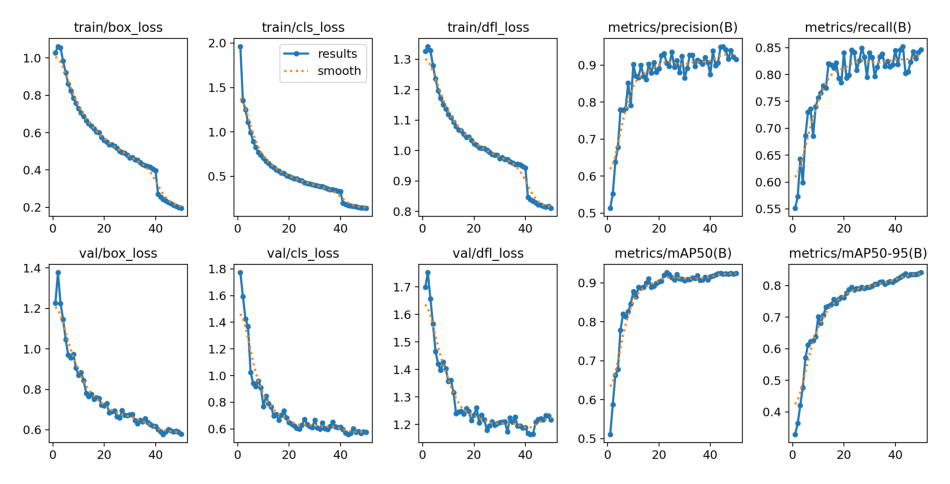

In [ ]:
#Here is about visualize the results:
image_path = '/content/runs/detect/run/results.png'

# Here is about read the image
img = cv2.imread(image_path)

# Here is about convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Here is about display the image
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

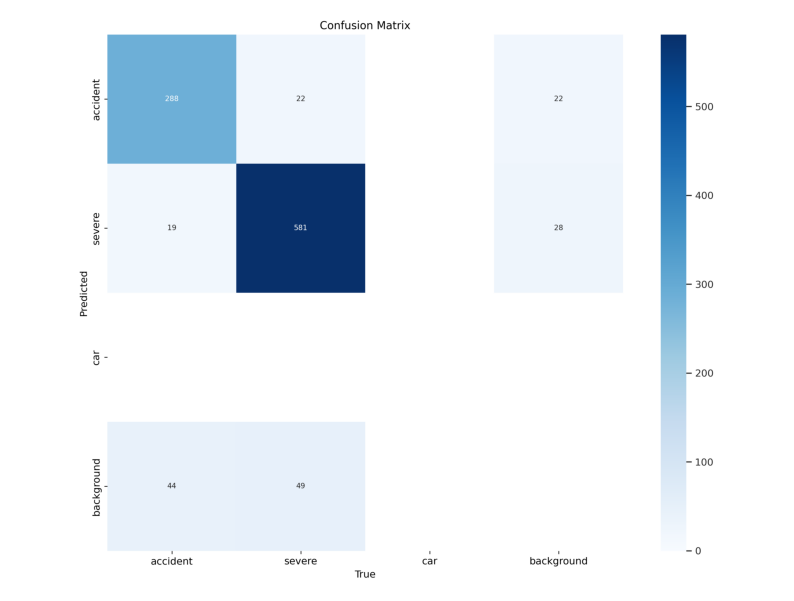

In [ ]:
image_path = '/content/runs/detect/run/confusion_matrix.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

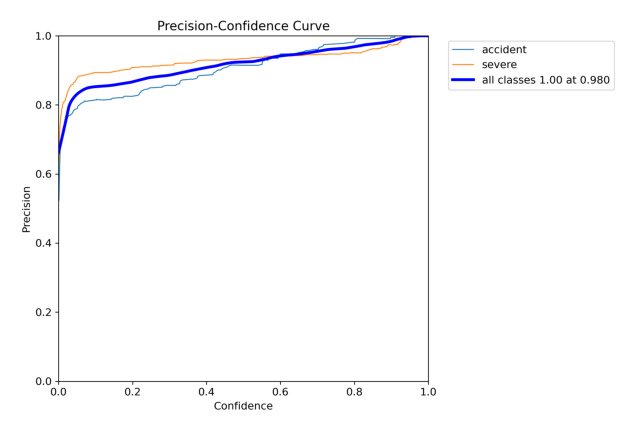

In [ ]:
image_path = '/content/runs/detect/run/P_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

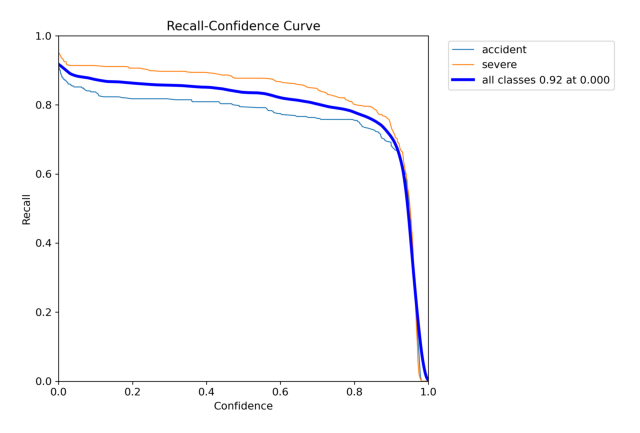

In [ ]:
image_path = '/content/runs/detect/run/R_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

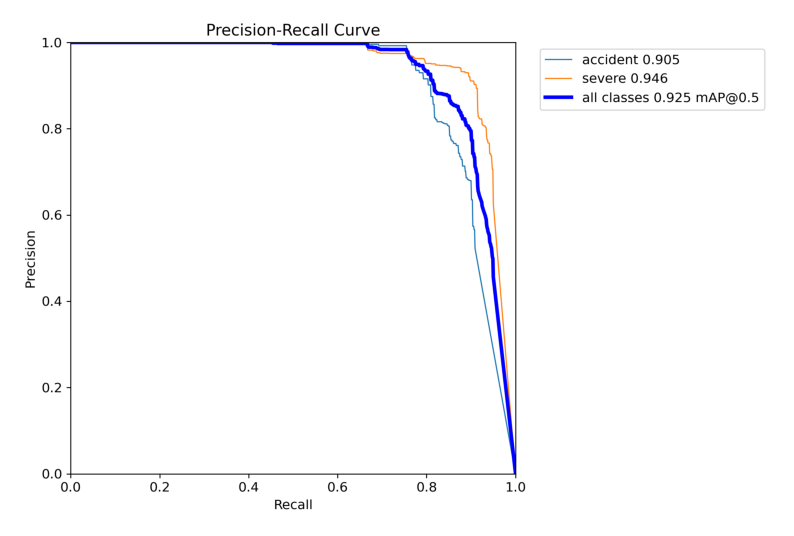

In [ ]:
image_path = '/content/runs/detect/run/PR_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

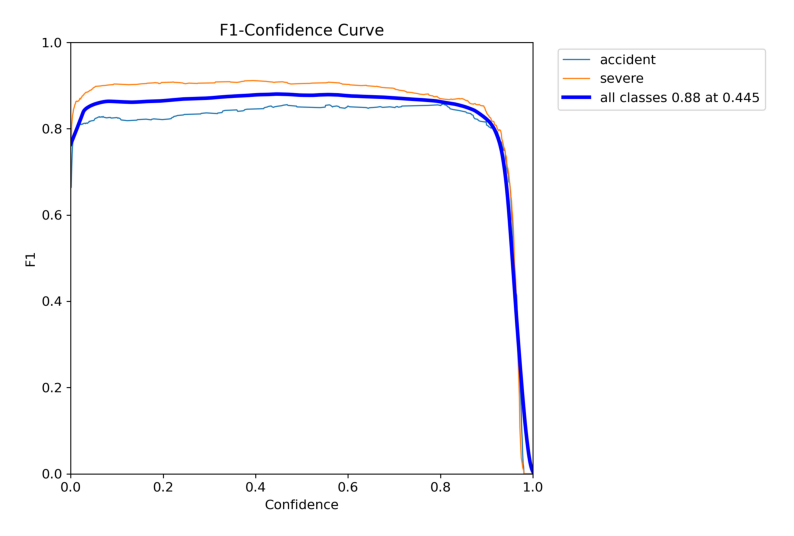

In [ ]:
image_path = '/content/runs/detect/run/F1_curve.png'

img = cv2.imread(image_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()